# Experimental Evaluation

MIFE scheme, we used ElGamal as the public-key encryption scheme

This notebook was runned with a HP Laptop 14s-dq1xxx with a 1GHz Intel Core i5 and 8GB RAM running Windows 10, 64 bit and Python 3.10 using `PyCryptoDome` and `numpy`

We first begin by generating some 1024 bit $G, P$ parameters that will be recycled for the whole experiment, since it is the most time consuming operation

In [1]:
from utils import get_GP, generate_gp

G, P = get_GP(load = True, nbits = 1024)

After this we proceed to show an initial representation of the tree, and the following operations

1. **Tree generation and population**: The tree nodes are initialized depending on the $N$ value and a dataset is added
2. **Noise addition**: Noise is added to each node
3. **Encryption**: Each node is encypted. Note that the result of *ElGamal* encryption gives two large values of which only the first two digits are represented in the tree

Num_leaves: 16, Num_nodes: 31


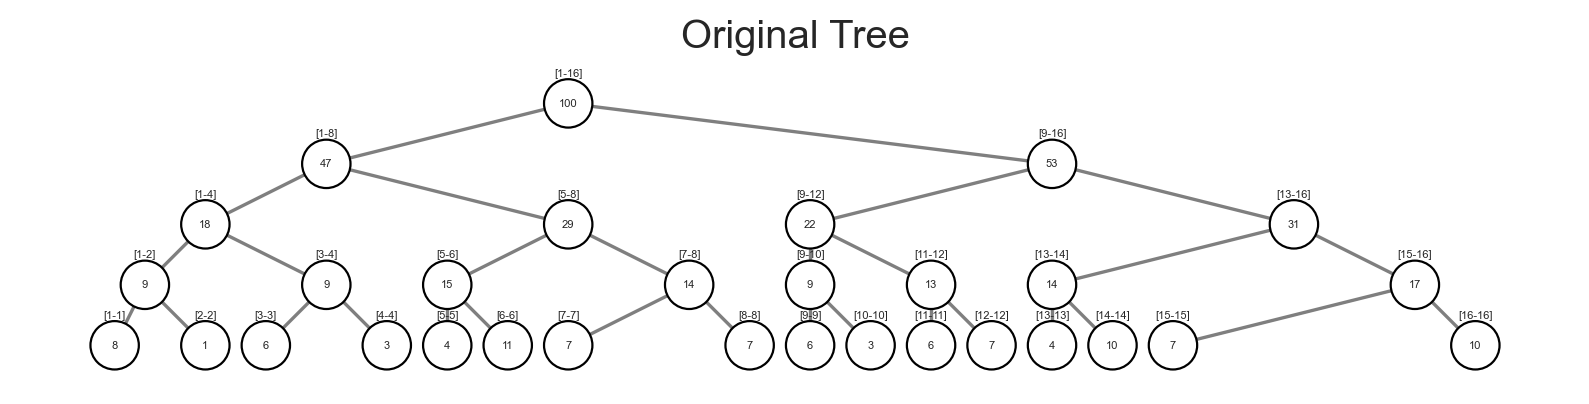

Query [14, 16]: 27


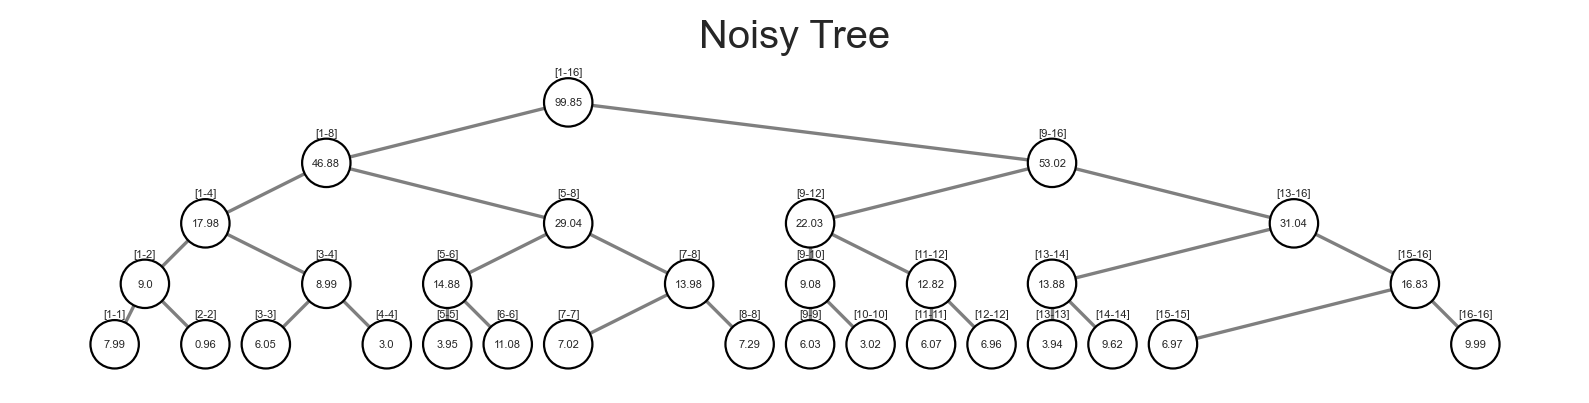

Query [14, 16]: 26.45577396671319


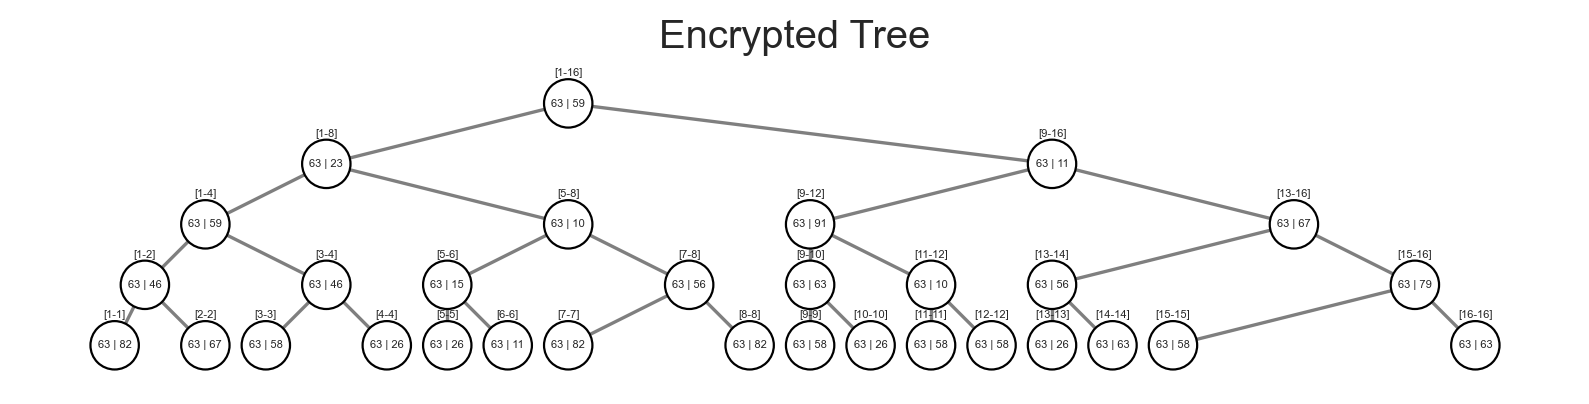

Query [14, 16]: 25
Query [14, 16]: 25
{'generateAndPopulate': 0.0007702000439167023, 'generateKeys': 0.5788941383361816, 'addNoise': 6.560003384947777e-05, 'encrypt': 0.35041284561157227}


In [13]:
import random
import numpy as np
from utils import *
from entities import Curator
import matplotlib as mpl

dpi_0 = mpl.rcParams['figure.dpi']
mpl.rcParams['figure.dpi'] = 200


N = 4
DATASET_SIZE = 100

print(f"Num_leaves: {2**N}, Num_nodes: {2**(N+1)-1}")

x = np.random.randint(1, 2**N+1, DATASET_SIZE)
C = Curator(N, x, G=G, P=P)
query = random.randint(1, 2**N-1)
query = [query, random.randint(query+1, 2**N)]
plot_tree(C.T, "Original Tree")
print(f"Query {query}: {C.read(query)}")
C.add_noise(10)
plot_tree(C.T, "Noisy Tree")
print(f"Query {query}: {C.read(query)}")
C.encrypt()
plot_tree(C.T, "Encrypted Tree")
print(f"Query {query}: {C.read(query)}")
print(f"Query {query}: {C.read(query, f_key=True)}")
print(C.times)
# print(C.mife.dec_l1(C.T.get_values()))

In [3]:
import pandas as pd

N_values = range(5, 11)
Dataset_Sizes = [100, 500, 1000, 10000]

df1 = pd.DataFrame(columns=['Dataset Size', 'Number of Leaves', 'Time (ms)'])
df2 = pd.DataFrame(columns=['Total Number of Tree Nodes', 'Laplacian Noise', 'Key Generation', 'Encryption', 'Tree Generation(Dataset size = 10000)', 'Total Time'])

for dataset_size in Dataset_Sizes:
    for N in N_values:
        x = np.random.randint(1, 2**N, dataset_size)
        C = Curator(N, x, G=G, P=P)
        C.add_noise(10)
        C.encrypt()
        df1 = pd.concat([df1, pd.DataFrame({'Dataset Size': [dataset_size], 'Number of Leaves': [2**N], 'Time (ms)': [C.times["generateAndPopulate"]*1000]})], ignore_index=True)
        if dataset_size == 10000:
            df2 = pd.concat([df2, pd.DataFrame({'Total Number of Tree Nodes': [2**(N+1)-1], 'Laplacian Noise': [C.times["addNoise"]], 'Key Generation': [C.times["generateKeys"]], 'Encryption': [C.times["encrypt"]],'Tree Generation(Dataset size = 10000)': [C.times["generateAndPopulate"]], 'Total Time': [sum(C.times.values())]})], ignore_index=True)
        # print(N, dataset_size, C.times)

# save to excel
# df1.to_excel("cw2_1.xlsx")
# df2.to_excel("cw2_2.xlsx")

In [4]:
df1

,Dataset Size,Number of Leaves,Time (ms)
0,100,32,0.3275
1,100,64,0.4815
2,100,128,0.4539
3,100,256,0.6926
4,100,512,1.1724
5,100,1024,2.7412
6,500,32,1.6426
7,500,64,1.7322
8,500,128,1.7188
9,500,256,2.3515


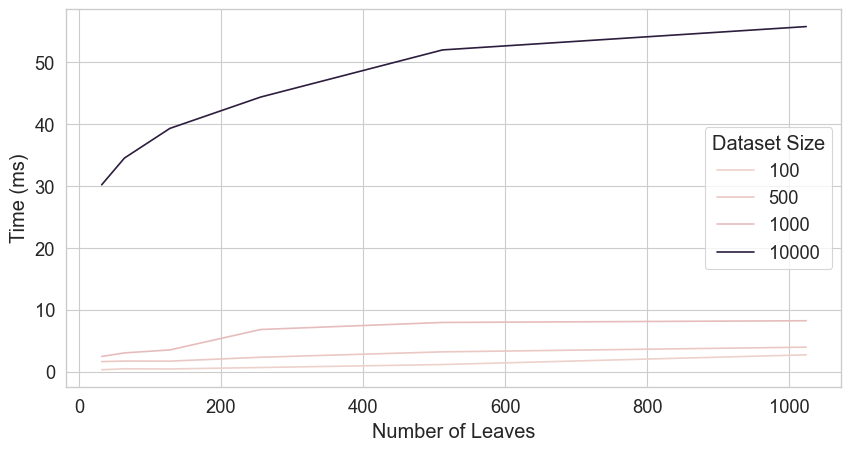

In [5]:
# draw the graph number of leaves vs time as a graph and points
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['figure.dpi'] = dpi_0

sns.set_theme(style="whitegrid")
sns.set_context("paper", font_scale=1.5)
plt.figure(figsize=(10, 5))
ax = sns.lineplot(x="Number of Leaves", y="Time (ms)", hue="Dataset Size", data=df1)



In [6]:
df2

,Total Number of Tree Nodes,Laplacian Noise,Key Generation,Encryption,Tree Generation(Dataset size = 10000),Total Time
0,63,0.000146,0.958605,0.653254,0.030223,1.642227
1,127,0.000219,1.892498,1.289893,0.034539,3.217149
2,255,0.000436,4.106747,2.655997,0.039336,6.802516
3,511,0.000779,7.964437,5.252489,0.044407,13.262111
4,1023,0.001660,16.386053,10.780267,0.052021,27.220001
5,2047,0.004975,34.205822,21.332881,0.055793,55.599471


Finally we capture a, fully unrealistic/worst-case scenario, retrieve the values from all the leaves of a 1024 leaves tree

In [7]:
import time

N = 10

x = np.random.randint(1, 2**N, 10000)
C = Curator(N, x, G=G, P=P)
interval = (10, 16)
interval = (interval, C.read(interval))
C.encrypt()

In [8]:

t0 = time.perf_counter()
checksum = sum([C.T.query_interval([i, i]) for i in range(1, 2**N+1)])

if checksum == 10000:
    print("Time to retrieve all leaves: ", round((time.perf_counter() - t0, 5)*1000, 3), "ms", sep="")
else:
    print("Error", time.time() - t0)
t0 = time.perf_counter()

print(f"Query {interval[0]}: {interval[1]}")
t0 = time.perf_counter()
checksum = C.read(interval[0])
print(f"Time to retrieve interval: {round(1000*(time.perf_counter() - t0), 2)}ms, checksum: {checksum}")
t0 = time.perf_counter()
checksum = C.read((interval[0]), f_key=True)
print(f"Time to retrieve interval with functional key: {round(1000*(time.perf_counter() - t0), 2)}ms, checksum: {checksum}")

from entities import generate_f_key

f_key = generate_f_key(C.mife.msk, P)
print(f"Time to generate functional key for 1024 secret keys: {round(1000*(time.perf_counter() - t0), 2)}ms")


Time to retrieve all leaves: 347.21000000000004ms
Query (10, 16): 76
Time to retrieve interval: 2.05ms, checksum: 76
Time to retrieve interval with functional key: 8.78ms, checksum: 76
Time to generate functional key for 1024 secret keys: 11.77ms
